In [1]:
import pandas as pd
import numpy as np
from generators import UniversalGenerator, Demand2
from utils import plot_path, get_params, SimOutput

In [2]:
# sp = pd.read_csv('sp2.csv')
# sp.set_index('month', inplace=True)
# sp = sp.map(ast.literal_eval)
# 
# cp3 = pd.read_csv('cp3.csv')
# cp3.set_index('month', inplace=True)
# cp3['tot_range'] = cp3['tot_range'].apply(ast.literal_eval)
# cp3['norm_range'] = cp3['norm_range'].apply(ast.literal_eval)
sp, cp3 = get_params()

In [3]:
# Set User Parameters

P = np.array([[0.7, 0.3],
                [0.3, 0.7]])

installed_capacity = 64044.6
reduction = 0.75

# Initialize Supply Generator
t_pars = sp['norm_range']
total = UniversalGenerator(t_pars, installed_capacity, P, reduction)


# Initialize Demand Generator
d_pars = cp3['norm_range']
d_scale = cp3['scaling_factor']
# d_scale = cp3['scaling_factor'] / cp3['scaling_factor']  # Makes the scaling factor = 1, as we are sampling from the total range
demand = Demand2(d_pars, d_scale)

dates = total.dr  # Get the date range

Prop = 0.0684931506849315
Total deficit = -1248.2208065212908


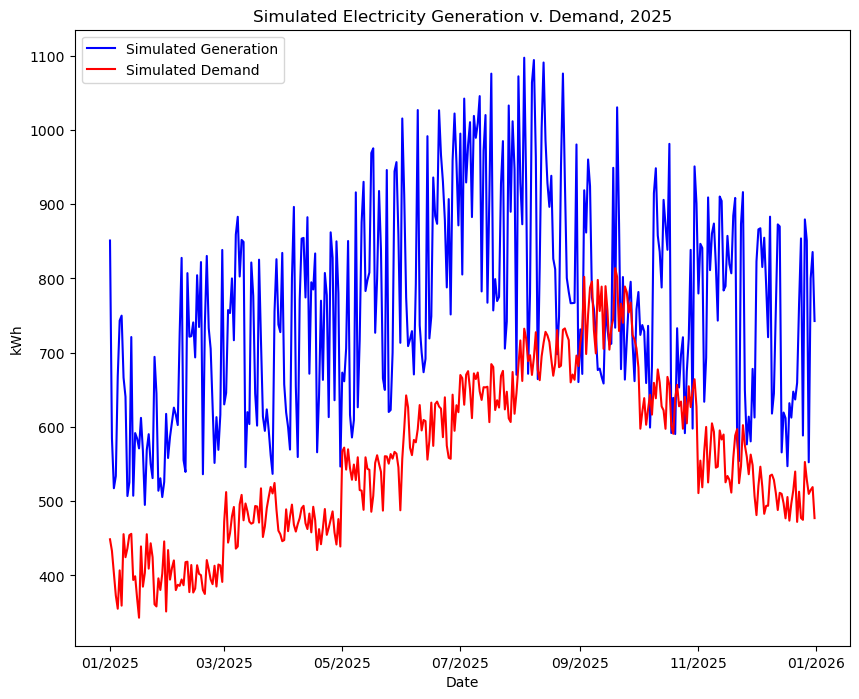

In [4]:
g_path = total.simulate_year()
d_path = demand.simulate_year()

prop = np.sum(d_path > g_path) / 365
num_ruin = np.sum(d_path > g_path)

delta = g_path - d_path
total_deficit = np.sum(np.where(delta < 0, delta, 0))

print(f"Prop = {prop}")
print(f"Total deficit = {total_deficit}")

plot_path(dates, g_path, d_path)

In [5]:
# 1000 Iterations: Raw Simulation

demand_paths = []
gen_paths = []

props = []
total_deficits = []
deltas = []

for i in range(1000):
    gen = total.simulate_year()
    dem = demand.simulate_year()
    gen_paths.append(gen)
    demand_paths.append(dem)
    
    # Output Variable --- Deltas
    delta = gen - dem
    deltas.append(delta)
    
    # Output Variable --- Deficits
    total_deficit = np.sum(np.where(delta < 0, delta, 0))
    total_deficits.append(total_deficit)
    
    # Output Variable --- Props
    prop = np.sum(dem > gen) / 365
    props.append(prop)

theta ~= 0.061389041095890405
var_theta ~= 0.00017512742353161944
mu_def ~= -1044.8133639608932
var_def ~= 79859.4735400216


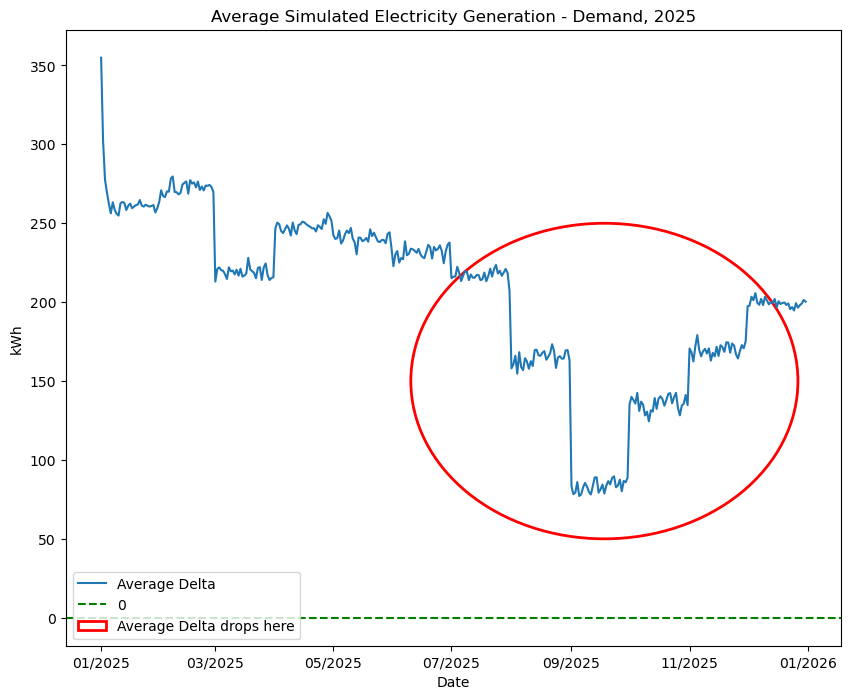

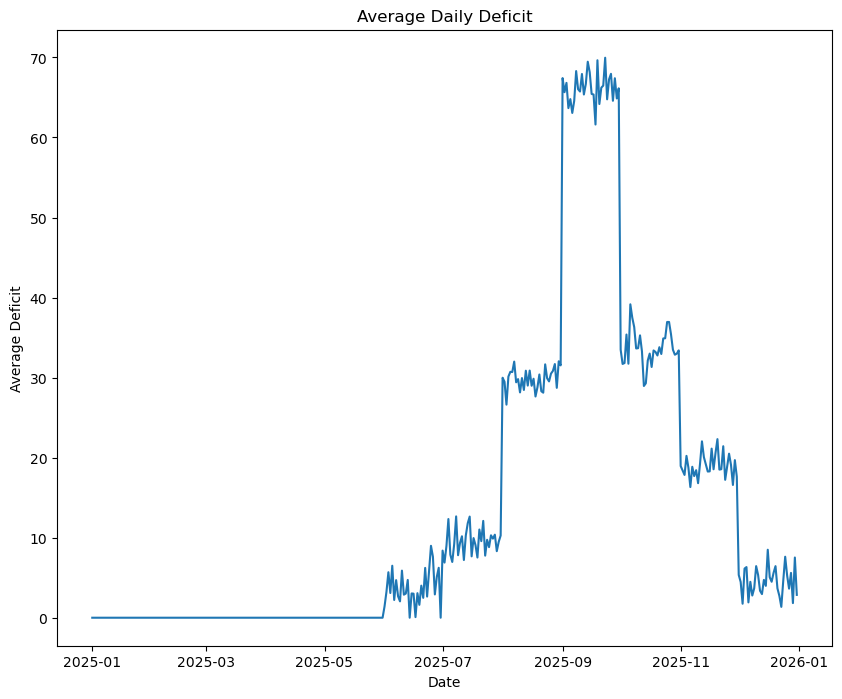

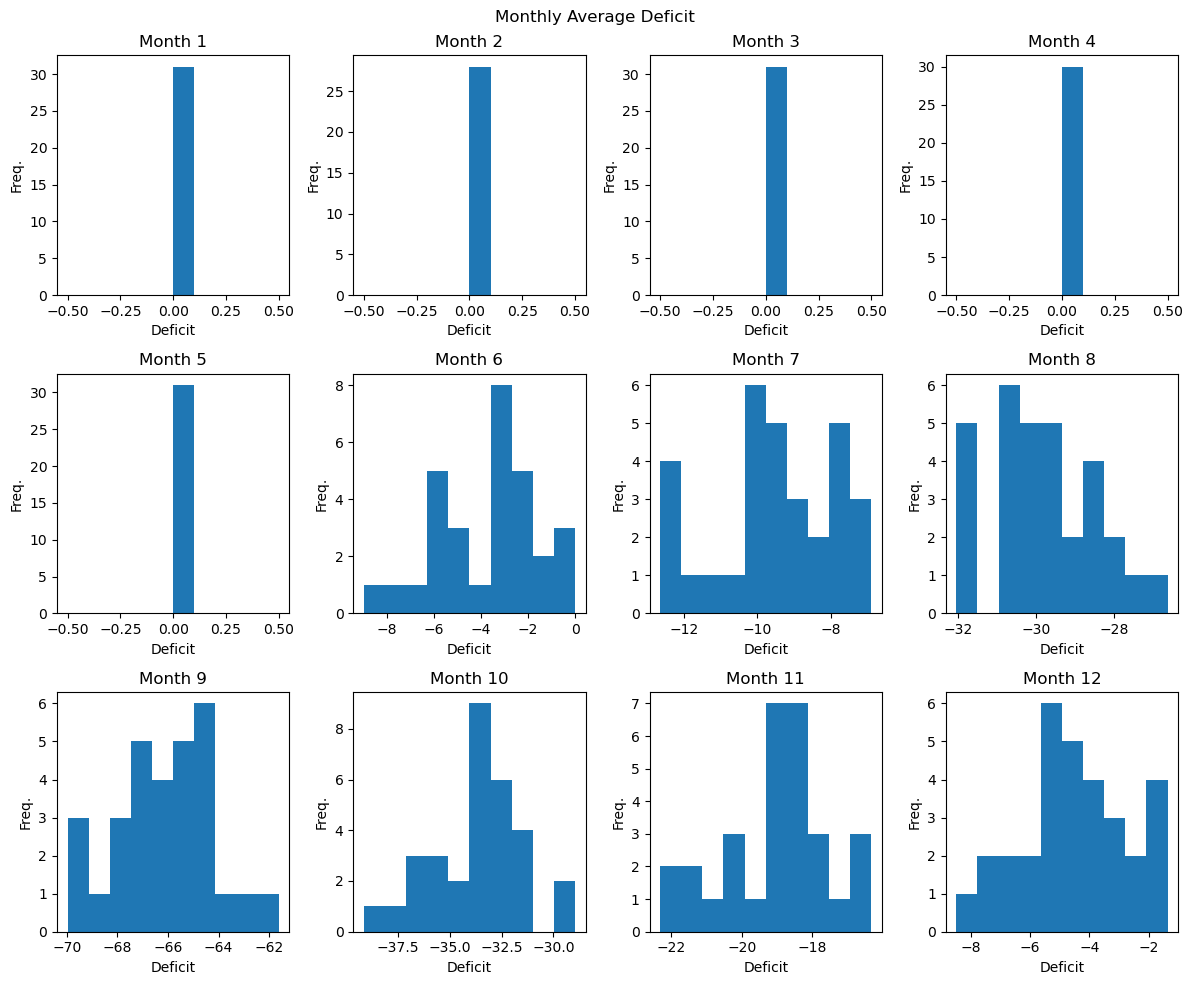

In [8]:
raw_sim = SimOutput(props, deltas, total_deficits, dates)
raw_sim.plot_avg_daily_delta()
raw_sim.plot_daily_neg_delta()
raw_sim.plot_monthly_neg_delta()
raw_sim.output_report("Raw Sim")

In [9]:
# 1000 Iterations: Antithetic Variables
demand_paths = []
gen_paths = []

props = []
total_deficits = []
deltas = []
for i in range(1000):
    gen = total.simulate_year_anthithetic()
    dem = demand.simulate_year_antithetic()
    gen_paths.append(gen)
    demand_paths.append(dem)
    
    # Output Variable --- Deltas
    delta = gen - dem
    deltas.append(delta)
    
    # Output Variable --- Deficits
    total_deficit = np.sum(np.where(delta < 0, delta, 0))
    total_deficits.append(total_deficit)
    
    
    # Output Variable --- Props
    prop = np.sum(dem > gen) / 365
    props.append(prop)

theta ~= 0.06120547945205479
var_theta ~= 0.00015429836742353166
mu_def ~= -1026.8247867497942
var_def ~= 66506.42660678651


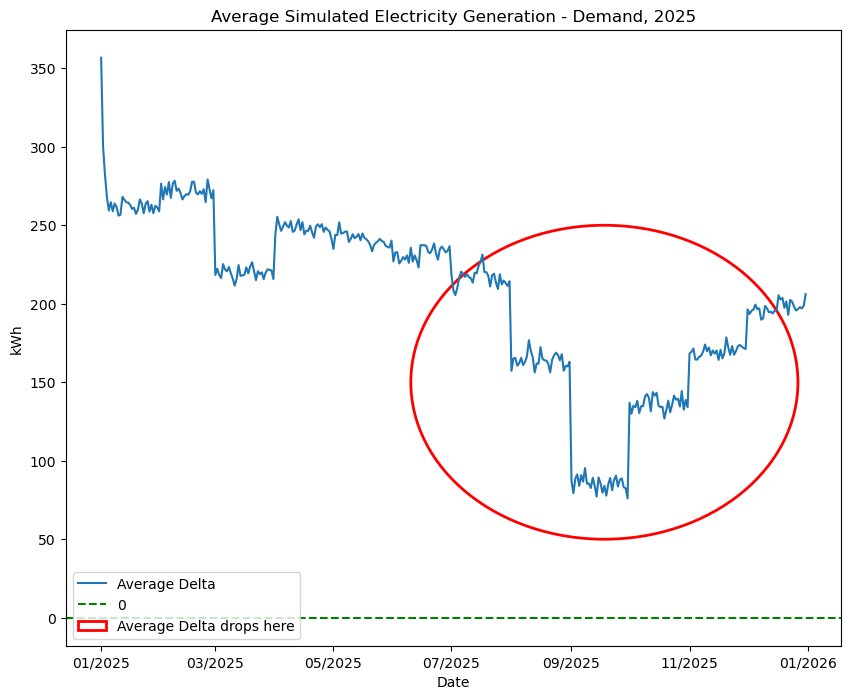

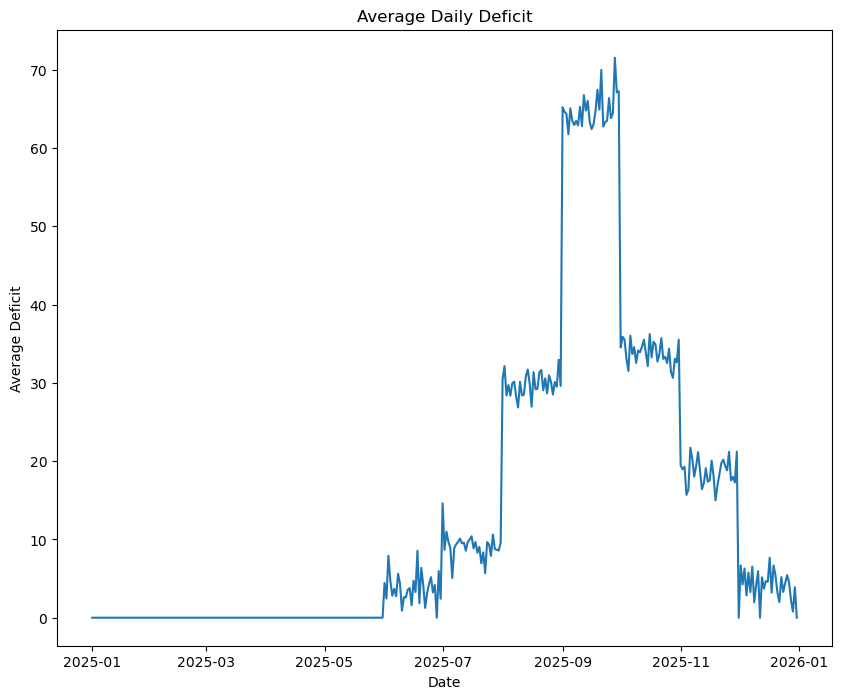

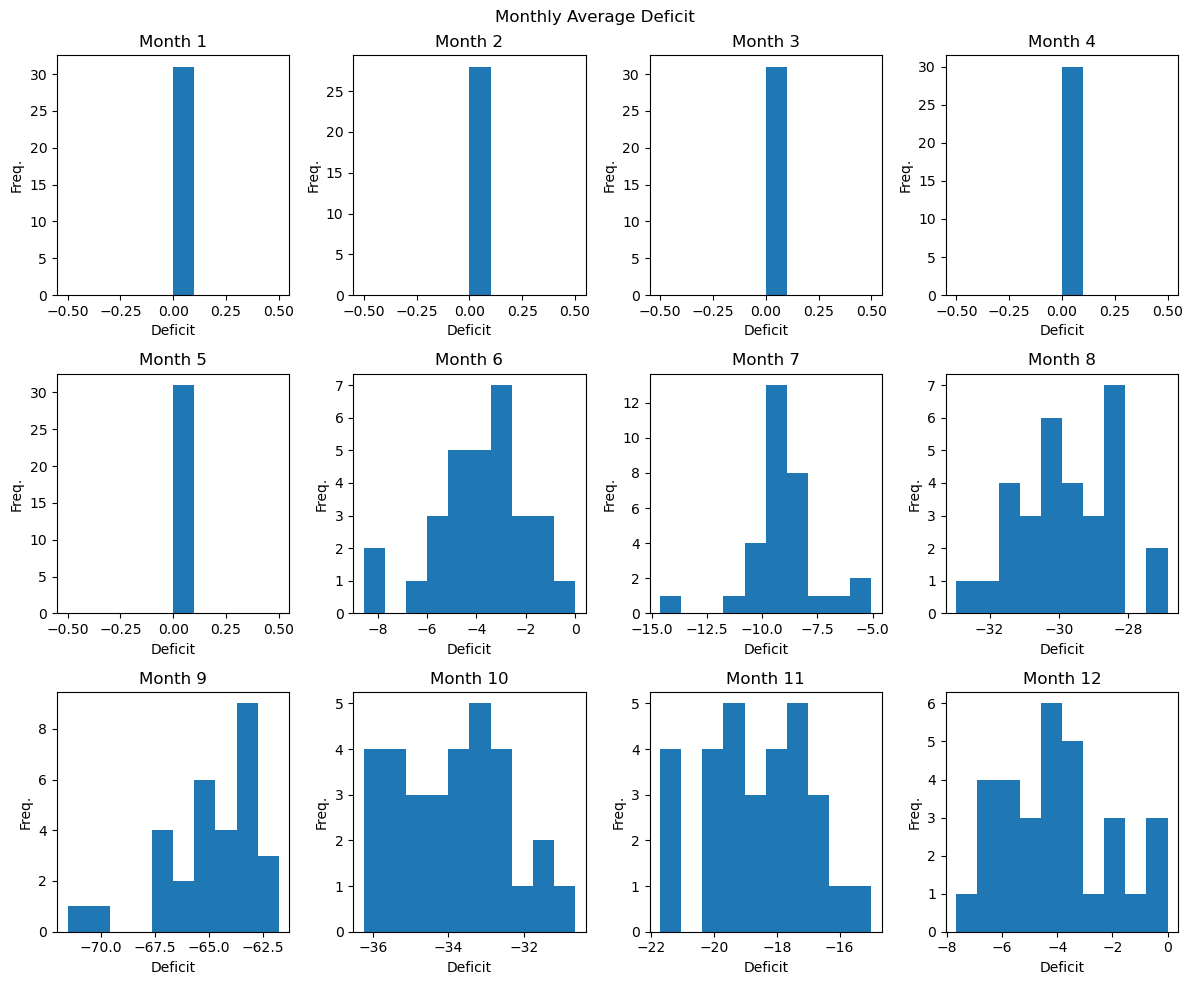

In [10]:
antithetic_sim = SimOutput(props, deltas, total_deficits, dates)
antithetic_sim.plot_avg_daily_delta()
antithetic_sim.plot_daily_neg_delta()
antithetic_sim.plot_monthly_neg_delta()

In [11]:
E_Y = antithetic_sim.theta
var_Y = antithetic_sim.var_theta

Y = np.random.normal(E_Y, np.sqrt(var_Y), 1000)
cov_xy = np.cov(raw_sim.total_deficits, Y)[0, 1]

c_star = (-1 * cov_xy) / var_Y

In [12]:
demand_paths = []
gen_paths = []

props = []
deltas = []
ctrl_defs = []

ctrl_props = []
for i in range(1000):
    gen = total.simulate_year_anthithetic()
    dem = demand.simulate_year_antithetic()    
    gen_paths.append(gen)
    demand_paths.append(dem)
    
    y = np.random.normal(E_Y, np.sqrt(var_Y))

    # Output Variable --- Deltas
    delta = gen - dem
    deltas.append(delta)
    
    # Output Variable --- Props
    prop = np.sum(dem > gen) / 365
    props.append(prop)
    
    # Output Variable --- Deficits
    total_deficit = np.sum(np.where(delta < 0, delta, 0))
    # deficits.append(total_deficit)
    
    ctrl = total_deficit + (c_star * (y - E_Y))
    ctrl_defs.append(ctrl)
    

theta ~= 0.06165205479452055
var_theta ~= 0.00015741783449052356
mu_def ~= -1047.4963678536228
var_def ~= 63991.49909680808


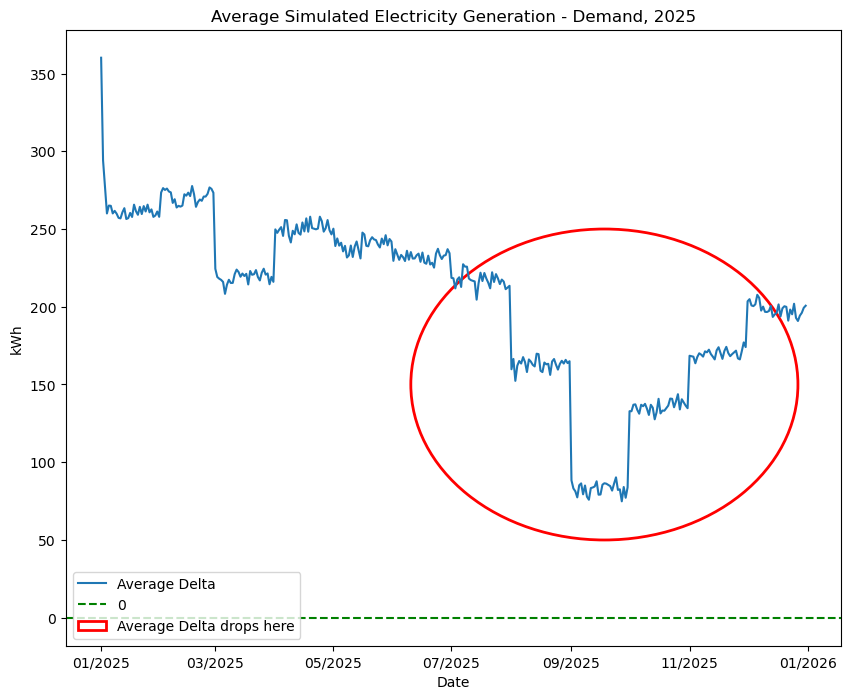

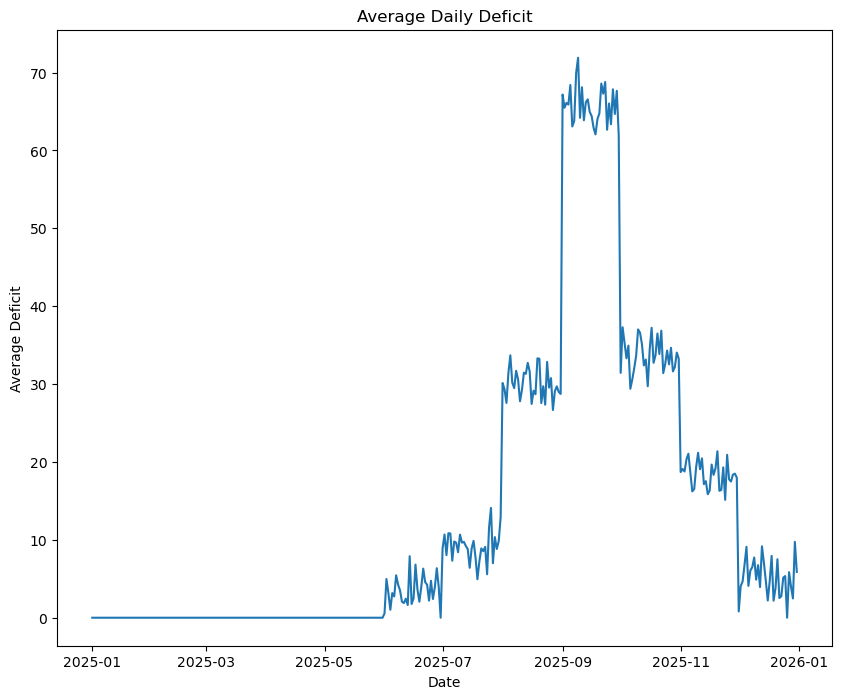

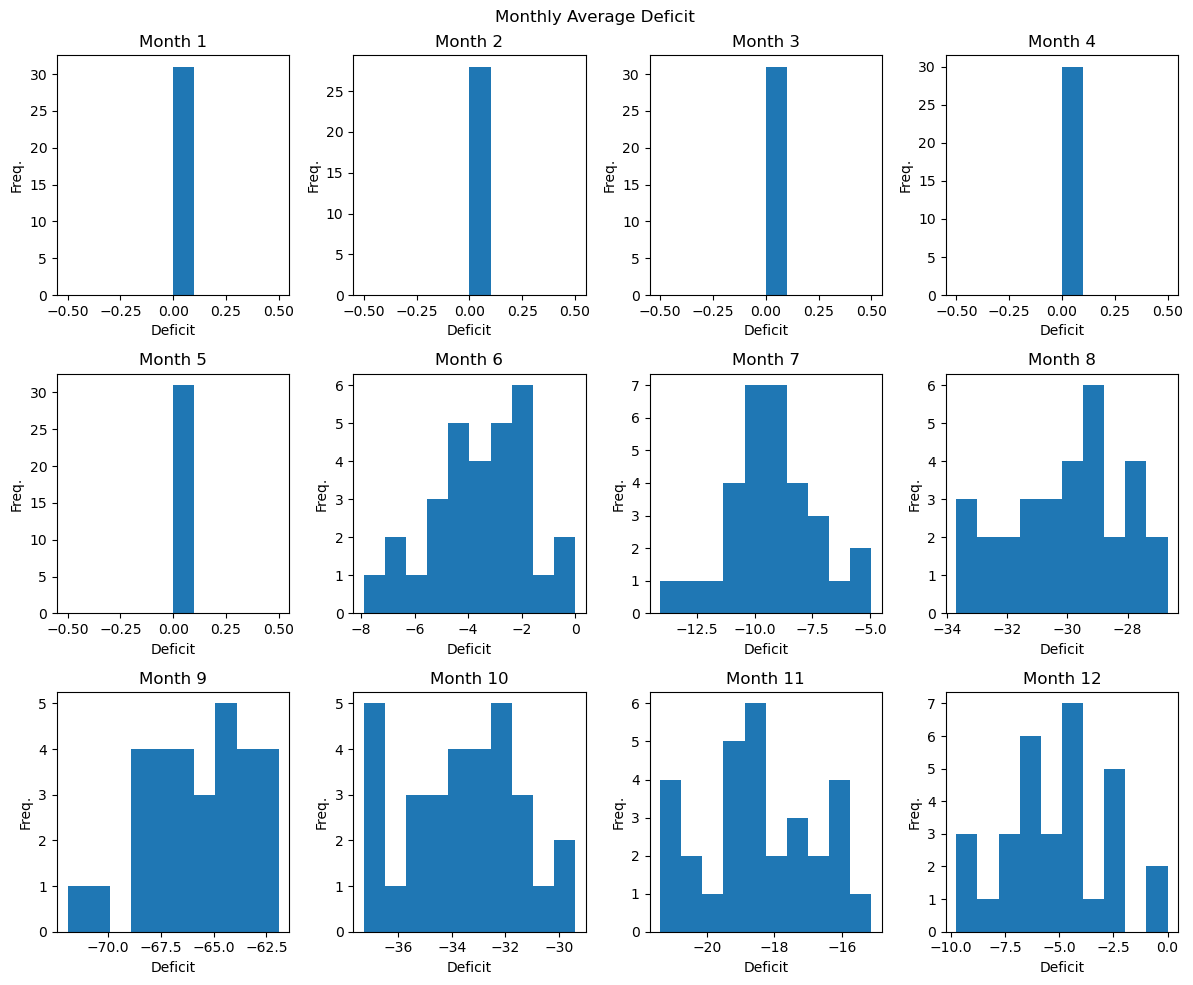

In [13]:
ctrl_sim = SimOutput(props, deltas, ctrl_defs, dates)
ctrl_sim.plot_avg_daily_delta()
ctrl_sim.plot_daily_neg_delta()
ctrl_sim.plot_monthly_neg_delta()